## Problem 2
### Milad Heidari
### Student Number: 98101469

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import torch.nn as nn

In [2]:
# set device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### A)

In [3]:
df = pd.read_csv('data/international_matches.csv')
df.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


#### B)

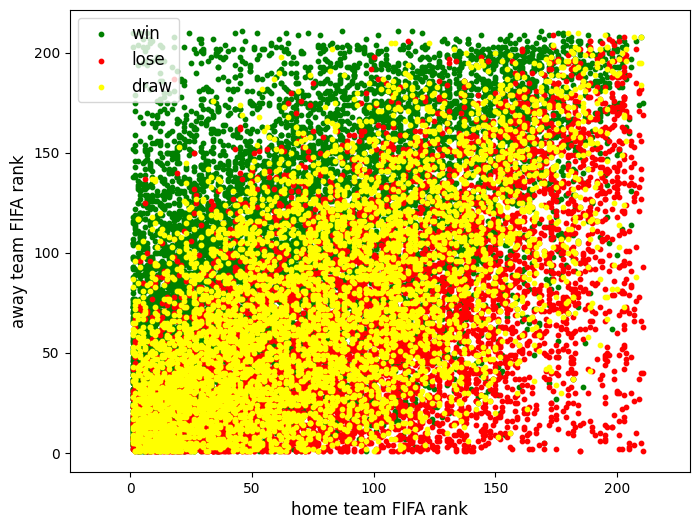

In [4]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

draw_idx = df['home_team_result'] == 'Draw'
win_idx = df['home_team_result'] == 'Win'
lose_idx = df['home_team_result'] == 'Lose'

ax.scatter(df.loc[win_idx, 'home_team_fifa_rank'],
           df.loc[win_idx, 'away_team_fifa_rank'],
           s=10,
           c='green',
           label='win',
          )
ax.scatter(df.loc[lose_idx, 'home_team_fifa_rank'],
           df.loc[lose_idx, 'away_team_fifa_rank'],
           s=10,
           c='red',
           label='lose',
          )

ax.scatter(df.loc[draw_idx, 'home_team_fifa_rank'],
           df.loc[draw_idx, 'away_team_fifa_rank'],
           s=10,
           c='yellow',
           label='draw',
          )

ax.set_xlabel('home team FIFA rank', size=12)
ax.set_ylabel('away team FIFA rank', size=12);
ax.set_xlim([-25, 230])
ax.legend(prop={'size': 12});

#### C)

In [5]:
# removing invalid data
valid_filter = np.logical_and(df['home_team_total_fifa_points'] != 0, df['away_team_total_fifa_points'] != 0)
df_valid = df.loc[valid_filter, :]
df_valid = df_valid.loc[
    :, 
    ['home_team_total_fifa_points',
    'home_team_fifa_rank',
    'away_team_total_fifa_points',
    'away_team_fifa_rank',     
    'home_team_result',
    ]]

# filter out the nan values
df_valid = df_valid.loc[df_valid.apply(lambda x: x.isna().sum() == 0, axis=1), :]

df_valid

,home_team_total_fifa_points,home_team_fifa_rank,away_team_total_fifa_points,away_team_fifa_rank,home_team_result
14250,260,114,112,158,Win
14251,245,120,208,129,Draw
14252,298,108,364,88,Win
14253,325,101,328,98,Win
14254,338,96,221,127,Lose
...,...,...,...,...,...
23916,932,180,1040,153,Win
23917,895,192,1105,135,Lose
23918,1526,28,1387,60,Lose
23919,1553,23,1499,35,Lose


In [6]:
# create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, examples, labels, transform=None, target_transform=None):
        self.examples = examples
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.labels)
    
    
    def __getitem__(self, idx):
        example = self.examples.iloc[idx, :]
        label = self.labels.iloc[idx]
        if self.transform is not None:
            example = self.transform(example)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return example, label

    
def target_map(label):
    label_map = {'Win': 0, 'Draw': 1, 'Lose': 2}
    return label_map[label]

In [7]:
# creating a dataset
dataset = CustomDataset(
    df_valid.iloc[:, :-1],
    df_valid.iloc[:, -1],
    transform=lambda x: torch.tensor(x),
    target_transform=target_map
)

In [8]:
# train-test split
train_size = int(0.75 * len(df_valid))
test_size = len(df_valid) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

In [9]:
# checking size of test set and train set
print(f'training set size: {len(train_set)}')
print(f'test set size: {len(test_set)}')

training set size: 7195
test set size: 2399


#### D)

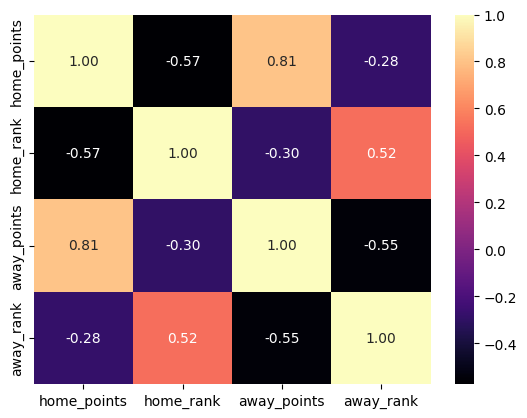

In [10]:
# computing correlation matrix

X = df_valid.iloc[:, :-1].to_numpy()
m, n = X.shape
mu_X = np.mean(X, axis=0)
variances = np.mean((X-mu_X)**2, axis=0).reshape(-1, 1)
variances = np.sqrt(variances @ variances.T)
Z = (X - mu_X).T @ (X - mu_X) / m
correlation_matrix = Z / variances
ax_labels = ['home_points', 'home_rank', 'away_points', 'away_rank']
sns.heatmap(correlation_matrix, cmap='magma', annot=True, fmt=".2f", xticklabels=ax_labels, yticklabels=ax_labels);

In [11]:
# defining neural network arcitecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear_relu_stack(x)
        x = self.sigmoid(x)
        return x

In [12]:
# create an instance of the model defined above
model = NeuralNetwork().to(device)
model.train()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [13]:
# setting hyperparameter
learning_rate = 5e-2
batch_size = 64
epochs = 25

In [14]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # forward prop
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        num_correct += (y_pred.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100,2)}%')
    
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            num_correct += (y_pred.argmax(dim=1) == y).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')
            

In [16]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    print()

epoch 1 ==================================================
train_loss: 1.047110915184021
Train Accuracy: 44.73%
Test Accuracy: 48.06%

epoch 2 ==================================================
train_loss: 0.9878373146057129
Train Accuracy: 48.8%
Test Accuracy: 47.98%

epoch 3 ==================================================
train_loss: 0.8568505644798279
Train Accuracy: 52.15%
Test Accuracy: 51.52%

epoch 4 ==================================================
train_loss: 1.0630768537521362
Train Accuracy: 54.0%
Test Accuracy: 55.52%

epoch 5 ==================================================
train_loss: 1.0597363710403442
Train Accuracy: 55.11%
Test Accuracy: 57.77%

epoch 6 ==================================================
train_loss: 1.0637129545211792
Train Accuracy: 55.39%
Test Accuracy: 55.06%

epoch 7 ==================================================
train_loss: 1.0104010105133057
Train Accuracy: 56.04%
Test Accuracy: 58.44%

epoch 8 ===========================================

#### E)

In [17]:
# Features extracted using the last FIFA update (latest match)

# IRAN: FIFA rank=21, total FIFA points=1564
# USA: FIFA rank=15, total FIFA points=1633
# England: FIFA rank=5, total FIFA points=1761
# Wales: FIFA rank=18, total FIFA points=1588

# Iran is considered as home teamand other teams are away teams
apponents = ['USA', 'England', 'Wales']

with torch.no_grad():
    X = torch.tensor([
        [1564, 21, 1633, 15],
        [1564, 21, 1761, 5],
        [1564, 21, 1588, 18]
    ], device=device,dtype=torch.float32)

    y_pred = model(X)
    for i, y in enumerate(y_pred):
        y = nn.functional.softmax(y, dim=0)
        print(f'=========== match {i} ===========')
        print(f'Iran wins: {100 * np.round(y[0].item(), 2)}%')
        print(f'draw: {100 * np.round(y[1].item(), 2)}%')
        print(f'{apponents[i]} wins: {100 * np.round(y[2].item(), 2)}%')
        print()

=========== match 0 ===========
Iran wins: 31.0%
draw: 28.000000000000004%
USA wins: 41.0%

=========== match 1 ===========
Iran wins: 24.0%
draw: 25.0%
England wins: 50.0%

=========== match 2 ===========
Iran wins: 36.0%
draw: 30.0%
Wales wins: 34.0%

